# ⚡ Smoke Test Workflow (1–14)
이 구간은 빠르게 데이터 일부로 end-to-end 학습과 검증을 수행하는 스모크 테스트 플로우입니다. 아래 순서대로 각 셀을 실행하세요.

In [1]:
# 1) Import required libraries (smoke test)
import os, sys, math, json, random, contextlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch_geometric.datasets import AirfRANS
from torch_geometric.data import Data, Batch
from matplotlib.tri import Triangulation
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(42)
print('SmokeTest | PyTorch:', torch.__version__, '| CUDA?', torch.cuda.is_available())

SmokeTest | PyTorch: 2.8.0+cu128 | CUDA? True


In [2]:
# 2) Configuration (minimal for smoke)
from dataclasses import dataclass, asdict

@dataclass
class SmokeCfg:
    seed: int = 42
    task: str = 'scarce'
    root: str = 'Dataset'
    # subsample graph count for smoke
    limit_train: int = 180
    limit_val: int = 20
    # voxel/node subsampling targets
    target_min_nodes: int = 8_000
    target_max_nodes: int = 30_000
    voxel_frac: float = 0.01
    voxel_iters: int = 5
    # radius-graph
    global_radius: float = 0.02
    surface_radius: float = 0.01
    max_num_neighbors: int = 48
    surface_ring: bool = True
    # training
    batch_size: int = 3
    epochs: int = 20
    hidden: int = 128
    layers: int = 14
    lr: float = 1e-3
    weight_decay: float = 1e-2  # typical AdamW wd
    betas: tuple[float, float] = (0.9, 0.95)
    eps: float = 1e-8
    amp: bool = True
    # lr scheduler: 'cosine', 'cosine_warm_restarts', 'reduce_on_plateau', or None
    lr_scheduler: str | None = 'cosine'
    # cosine params
    cosine_T_max: int = 20  # epochs
    cosine_eta_min: float = 1e-6
    # warm restarts params
    wr_T_0: int = 10
    wr_T_mult: int = 1
    wr_eta_min: float = 1e-6
    # reduce on plateau params
    rop_factor: float = 0.5
    rop_patience: int = 5
    rop_min_lr: float = 1e-6

scfg = SmokeCfg()
set_seed(scfg.seed)
print('Smoke config:', asdict(scfg))

Smoke config: {'seed': 42, 'task': 'scarce', 'root': 'Dataset', 'limit_train': 180, 'limit_val': 20, 'target_min_nodes': 8000, 'target_max_nodes': 30000, 'voxel_frac': 0.01, 'voxel_iters': 5, 'global_radius': 0.02, 'surface_radius': 0.01, 'max_num_neighbors': 48, 'surface_ring': True, 'batch_size': 3, 'epochs': 20, 'hidden': 128, 'layers': 14, 'lr': 0.001, 'weight_decay': 0.01, 'betas': (0.9, 0.95), 'eps': 1e-08, 'amp': True, 'lr_scheduler': 'cosine', 'cosine_T_max': 20, 'cosine_eta_min': 1e-06, 'wr_T_0': 10, 'wr_T_mult': 1, 'wr_eta_min': 1e-06, 'rop_factor': 0.5, 'rop_patience': 5, 'rop_min_lr': 1e-06}


In [3]:
# 3) Load a tiny subset (train/val)
assert os.path.isdir(scfg.root), f"Dataset folder not found: {scfg.root}"
try:
    ds_train = AirfRANS(root=scfg.root, train=True, task=scfg.task)
    ds_test  = AirfRANS(root=scfg.root, train=False, task=scfg.task)
except TypeError:
    ds_train = AirfRANS(root=scfg.root, train=True)
    ds_test  = AirfRANS(root=scfg.root, train=False)

ids_train = list(range(min(scfg.limit_train+scfg.limit_val, len(ds_train))))
ids_val = ids_train[-scfg.limit_val:] if scfg.limit_val>0 else []
ids_train = ids_train[:scfg.limit_train] if scfg.limit_train>0 else ids_train
train_raw = Subset(ds_train, ids_train)
val_raw   = Subset(ds_train, ids_val) if ids_val else []
print('Loaded tiny subset:', len(train_raw), 'train |', len(val_raw) if isinstance(val_raw, Subset) else 0, 'val')

Loaded tiny subset: 180 train | 20 val


In [4]:
# 4) Node downsampling (voxel, preserve surface)
from torch_geometric.nn.pool import voxel_grid

@torch.no_grad()
def with_pos3(data: Data) -> Data:
    # Build 3D pos from data.pos or zeros; append to x
    x_orig = data.x
    if hasattr(data, 'pos') and data.pos is not None:
        pos = data.pos.to(dtype=x_orig.dtype, device=x_orig.device)
        if pos.size(1) < 3:
            pad = torch.zeros(pos.size(0), 3 - pos.size(1), device=pos.device, dtype=pos.dtype)
            pos3 = torch.cat([pos, pad], dim=1)
        else:
            pos3 = pos[:, :3]
    else:
        pos3 = torch.zeros(x_orig.size(0), 3, device=x_orig.device, dtype=x_orig.dtype)
    x_cat = torch.cat([x_orig, pos3], dim=1)
    new = Data(**{k: v for k, v in data})
    new.x = x_cat
    new.pos3_appended = True
    return new

# Note: keep features at 8D (original 5 + pos3). No dimensionality reduction.

def get_surface_mask(data: Data):
    if hasattr(data,'surf') and isinstance(data.surf, torch.Tensor) and data.surf.dtype==torch.bool:
        return data.surf.view(-1)
    x = data.x
    wall = x[:,2] if x.size(1)>=3 else torch.zeros(x.size(0))
    nxy = x[:,3:5] if x.size(1)>=5 else torch.zeros(x.size(0),2)
    return (wall < 1e-6) | (nxy.abs().sum(dim=1)>0)

def estimate_chord_length(pos: torch.Tensor):
    if pos.size(1)>=2:
        c = float(pos[:,0].max()-pos[:,0].min())
        if c>0: return c
    mins,_ = pos.min(dim=0); maxs,_ = pos.max(dim=0)
    return float((maxs-mins).norm().item())

@torch.no_grad()
def voxel_preserve_surface(data: Data, voxel_size: float):
    N = data.x.size(0)
    surf = get_surface_mask(data)
    si = torch.nonzero(surf, as_tuple=False).view(-1)
    vi = torch.nonzero(~surf, as_tuple=False).view(-1)
    if vi.numel()==0: return data
    pos = data.pos[:, :2] if hasattr(data,'pos') and data.pos is not None else data.x[:, :2]
    pos_v = pos[vi].cpu()
    cl = voxel_grid(pos_v, size=float(voxel_size), batch=torch.zeros(pos_v.size(0), dtype=torch.long))
    idx = torch.arange(pos_v.size(0))
    pairs = torch.stack([cl, idx], dim=1)[torch.argsort(cl)]
    pick = torch.ones(pairs.size(0), dtype=torch.bool)
    pick[1:] = pairs[1:,0] != pairs[:-1,0]
    keep_v = vi[pairs[pick,1].to(vi.device)]
    keep = torch.unique(torch.cat([si, keep_v], dim=0), sorted=True)
    new = Data()
    for k,v in data:
        if torch.is_tensor(v) and v.dim()>=1 and v.size(0)==N:
            new[k]=v[keep]
        else:
            new[k]=v
    new.subsample_keep_idx = keep
    new.subsample_voxel_size = float(voxel_size)
    return new

@torch.no_grad()
def adapt_voxel(data: Data, tmin: int, tmax: int, frac: float, iters: int):
    chord = estimate_chord_length(data.pos if hasattr(data,'pos') and data.pos is not None else data.x[:, :2])
    f = max(1e-5, float(frac))
    best = None
    for _ in range(iters):
        v = chord * f
        sub = voxel_preserve_surface(data, v)
        n = int(sub.x.size(0))
        if tmin <= n <= tmax:
            return sub
        mid = 0.5*(tmin+tmax)
        if n>0: f = min(1.0, max(1e-5, f*math.sqrt(n/mid)))
        best = sub if best is None or abs(n-mid) < abs(best.x.size(0)-mid) else best
    return best if best is not None else data

class VoxelWrapper(torch.utils.data.Dataset):
    def __init__(self, base):
        self.base = base
    def __len__(self):
        return len(self.base)
    def __getitem__(self, i):
        d = self.base[i]
        d_sub = adapt_voxel(d, scfg.target_min_nodes, scfg.target_max_nodes, scfg.voxel_frac, scfg.voxel_iters)
        # Append (x,y,z) position into node features here (pre-model)
        d_sub = with_pos3(d_sub)
        # Keep 8D: do NOT reduce features
        return d_sub

train_nodes = VoxelWrapper(train_raw)
val_nodes   = VoxelWrapper(val_raw) if isinstance(val_raw, Subset) else []
print('Downsampling + pos3 augmentation ready.')

Downsampling + pos3 augmentation ready.


In [5]:
# 4a) Utility: append 3D position to node features (x)
@torch.no_grad()
def with_pos3(data: Data) -> Data:
    # Build 3D pos from data.pos or zeros; append to x
    x_orig = data.x
    if hasattr(data, 'pos') and data.pos is not None:
        pos = data.pos.to(dtype=x_orig.dtype, device=x_orig.device)
        if pos.size(1) < 3:
            pad = torch.zeros(pos.size(0), 3 - pos.size(1), device=pos.device, dtype=pos.dtype)
            pos3 = torch.cat([pos, pad], dim=1)
        else:
            pos3 = pos[:, :3]
    else:
        pos3 = torch.zeros(x_orig.size(0), 3, device=x_orig.device, dtype=x_orig.dtype)
    x_cat = torch.cat([x_orig, pos3], dim=1)
    new = Data(**{k: v for k, v in data})
    new.x = x_cat
    new.pos3_appended = True
    return new

Reynolds number = 2.35 mil
Freestream velocity = 36.62 m/s


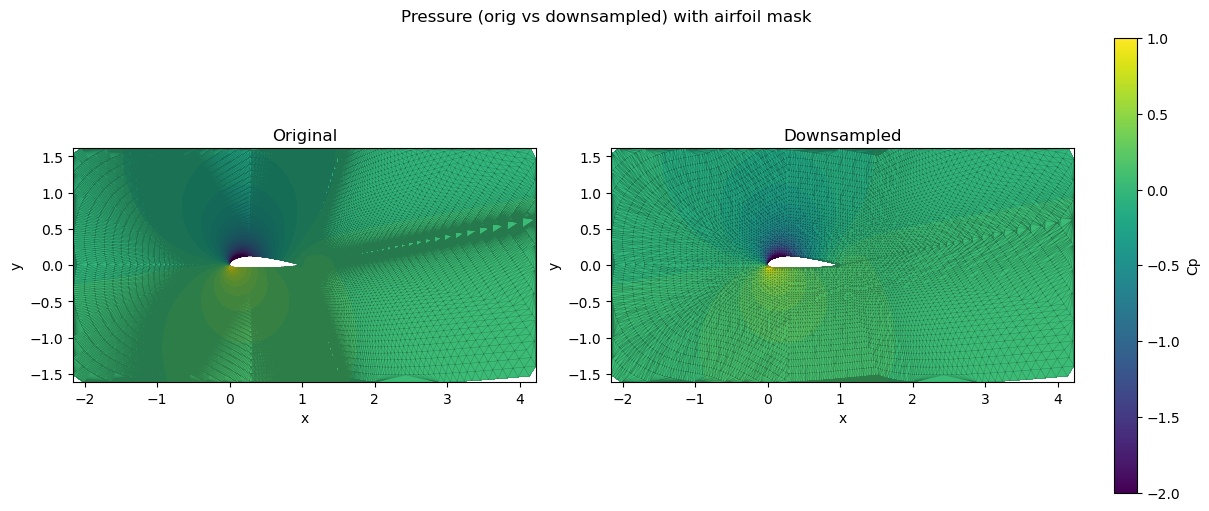

In [6]:
# 5) Visual compare: original vs downsampled (few samples)
from matplotlib.path import Path

def _to_xy(t: torch.Tensor):
    return t[:, :2].detach().cpu().float().numpy()

def _poly_from_surface(data: Data):
    try:
        mask = get_surface_mask(data)
        pts = (data.pos if hasattr(data,'pos') and data.pos is not None else data.x)[:, :2]
        pts = pts[mask].detach().cpu().numpy()
        if pts.shape[0] < 3: return None
        c = pts.mean(axis=0)
        ang = np.arctan2(pts[:,1]-c[1], pts[:,0]-c[0])
        order = np.argsort(ang)
        return Path(pts[order], closed=True)
    except Exception:
        return None

def plot_pair(orig: Data, sub: Data, field='y', col=2, title=None, show_mesh=True, mask_airfoil=True):
    xy_o = _to_xy(orig.pos if hasattr(orig,'pos') and orig.pos is not None else orig.x)
    xy_s = _to_xy(sub.pos  if hasattr(sub,'pos')  and sub.pos  is not None else sub.x)

    vx = orig.x[0,0]
    vy = orig.x[0,1]
    v = math.sqrt(vx*vx + vy*vy)
    q = 0.5 * v * v
    nu = 1.56e-5
    re = v / nu
    print(f"Reynolds number = {re / 1e6:.2f} mil")
    print(f"Freestream velocity = {v:.2f} m/s")

    z_o = getattr(orig, field)[:, col].detach().cpu().float().numpy() / q
    z_s = getattr(sub,  field)[:, col].detach().cpu().float().numpy() / q

    vmin = -2.0
    vmax = 1.0

    tri_o = Triangulation(xy_o[:,0], xy_o[:,1])
    tri_s = Triangulation(xy_s[:,0], xy_s[:,1])


    if mask_airfoil:
        for tri, data in [(tri_o, orig), (tri_s, sub)]:
            poly = _poly_from_surface(data)
            if poly is None: continue
            tris = tri.triangles
            centers = np.mean(np.stack([tri.x[tris], tri.y[tris]], axis=-1), axis=1)
            inside = poly.contains_points(centers)
            if inside is not None and inside.any():
                tri.set_mask(inside)
    fig, ax = plt.subplots(1,2, figsize=(12,5), constrained_layout=True)
    a1,a2=ax
    a1.tricontourf(tri_o, z_o, levels=50, vmin=-2.0, vmax=1, cmap='viridis')
    a2.tricontourf(tri_s, z_s, levels=50, vmin=-2.0, vmax=1, cmap='viridis')
    if show_mesh:
        a1.triplot(tri_o, color='k', lw=0.25, alpha=0.35)
        a2.triplot(tri_s, color='k', lw=0.25, alpha=0.35)
    for a, name in zip([a1,a2], ['Original','Downsampled']):
        a.set_aspect('equal','box'); a.set_title(name); a.set_xlabel('x'); a.set_ylabel('y')
    m = plt.cm.ScalarMappable(cmap='viridis'); m.set_clim(vmin,vmax)
    fig.colorbar(m, ax=ax, fraction=0.046, pad=0.04, label=f'Cp')
    if title: fig.suptitle(title)
    plt.show()

pair_ids = [0] if len(train_raw)>0 else []
if pair_ids:
    o = train_raw[pair_ids[0]]; s = train_nodes[pair_ids[0]]
    plot_pair(o,s, field='y', col=2, title='Pressure (orig vs downsampled) with airfoil mask')
else:
    print('No samples to visualize.')

In [ ]:
# 6) Build edge_index/edge_attr
# Prefer prebuilt graphs (from preprocess_edges_offline.py) to avoid on-the-fly edge building.
# If not available, fall back to inline building via preprocess_airfrans_edges.py
from types import SimpleNamespace
import importlib.util, sys, glob, os

USE_PREBUILT_EDGES = True
PREBUILT_ROOT = 'prebuilt_edges/scarce'  # change to your path if different
PREBUILT_TRAIN_DIR = f"{PREBUILT_ROOT}/train"
PREBUILT_TEST_DIR = f"{PREBUILT_ROOT}/test"

# Inline builder (fallback)
spec = importlib.util.spec_from_file_location('pre_air', os.path.abspath('preprocess_airfrans_edges.py'))
pre_air = importlib.util.module_from_spec(spec) if spec and spec.loader else None
if pre_air is not None:
    sys.modules[spec.name] = pre_air
    spec.loader.exec_module(pre_air)

class EdgeParams(pre_air.Params):
    pass

def build_edges_inline(data: Data) -> Data:
    p = EdgeParams(root=scfg.root, preset='scarce', task=scfg.task, include_test=False,
                   global_radius=scfg.global_radius, surface_radius=scfg.surface_radius,
                   max_num_neighbors=scfg.max_num_neighbors, surface_ring=scfg.surface_ring,
                   output_dir='__inline__', rebuild=True, limit=None, workers=1, use_processes=False,
                   aoa_min=None, aoa_max=None, aoa_index=2, filter_contains=None, sequential=True,
                   chunk_size=1, mem_highwater=100.0, gc_interval=1, max_active_futures=0)
    d = data.clone()
    return pre_air.build_edges_for_graph(d, p)

# Loader for prebuilt .pt graphs
def load_prebuilt_graphs(dir_path: str, limit: int | None = None):
    files = sorted(glob.glob(os.path.join(dir_path, 'graph_*.pt')))
    if limit is not None:
        files = files[:max(0, int(limit))]
    graphs = []
    for f in files:
        try:
            g = torch.load(f, map_location='cpu')
            graphs.append(g)
        except Exception as e:
            print(f"[prebuilt] failed to load {f}: {e}")
    return graphs

# Decide path: prebuilt vs inline
prebuilt_ok = USE_PREBUILT_EDGES and os.path.isdir(PREBUILT_TRAIN_DIR)
prebuilt_ok = prebuilt_ok and len(glob.glob(os.path.join(PREBUILT_TRAIN_DIR, 'graph_*.pt'))) > 0

if prebuilt_ok:
    # Use prebuilt train/test as train/val subsets
    train_edges = load_prebuilt_graphs(PREBUILT_TRAIN_DIR, limit=scfg.limit_train)
    val_edges = load_prebuilt_graphs(PREBUILT_TEST_DIR,  limit=scfg.limit_val) if scfg.limit_val > 0 else []
    print(f"[prebuilt] loaded {len(train_edges)} train and {len(val_edges) if isinstance(val_edges, list) else 0} val graphs from {PREBUILT_ROOT}")
else:
    # Fallback: build edges inline for downsampled nodes
    class EdgeWrapper(torch.utils.data.Dataset):
        def __init__(self, base): self.base=base
        def __len__(self): return len(self.base)
        def __getitem__(self, i):
            d = self.base[i]
            d2 = build_edges_inline(d)
            return d2
    train_edges = EdgeWrapper(train_nodes)
    val_edges   = EdgeWrapper(val_nodes) if isinstance(val_nodes, VoxelWrapper) and len(val_nodes)>0 else []
    print('Edge building wrapper ready (inline fallback).')

Edge building wrapper ready.


In [8]:
# 7a) Dataset-wise normalization (Standard Scaler on x and y)
@torch.no_grad()
class StandardScaler:
    def __init__(self, mean: torch.Tensor, std: torch.Tensor, eps: float = 1e-8):
        self.mean = mean.detach().cpu().float()
        self.std = std.detach().cpu().float().clamp_min(eps)
    def to(self, device, dtype=None):
        self.mean = self.mean.to(device)
        self.std = self.std.to(device)
        if dtype is not None:
            self.mean = self.mean.to(dtype)
            self.std = self.std.to(dtype)
        return self
    def transform(self, x: torch.Tensor) -> torch.Tensor:
        m = self.mean.to(x.device, dtype=x.dtype)
        s = self.std.to(x.device, dtype=x.dtype)
        return (x - m) / s
    def inverse(self, x: torch.Tensor) -> torch.Tensor:
        m = self.mean.to(x.device, dtype=x.dtype)
        s = self.std.to(x.device, dtype=x.dtype)
        return x * s + m

@torch.no_grad()
def fit_standard_scalers(ds) -> tuple[StandardScaler, StandardScaler]:
    sum_x = None; sumsq_x = None; n_x = 0
    sum_y = None; sumsq_y = None; n_y = 0
    for i in range(len(ds)):
        d = ds[i]
        x = d.x.detach().float(); y = d.y.detach().float()
        if sum_x is None:
            sum_x = torch.zeros(x.size(1)); sumsq_x = torch.zeros(x.size(1))
        if sum_y is None:
            sum_y = torch.zeros(y.size(1)); sumsq_y = torch.zeros(y.size(1))
        sum_x += x.sum(dim=0); sumsq_x += (x*x).sum(dim=0); n_x += x.size(0)
        sum_y += y.sum(dim=0); sumsq_y += (y*y).sum(dim=0); n_y += y.size(0)
        
    mean_x = sum_x / max(1, n_x)
    var_x = (sumsq_x / max(1, n_x)) - mean_x*mean_x
    std_x = torch.sqrt(var_x.clamp_min(1e-12))
    mean_y = sum_y / max(1, n_y)
    var_y = (sumsq_y / max(1, n_y)) - mean_y*mean_y
    std_y = torch.sqrt(var_y.clamp_min(1e-12))
    # Avoid zero std (e.g., constant channels) -> set to 1 to leave them unchanged
    std_x = torch.where(std_x < 1e-6, torch.ones_like(std_x), std_x)
    std_y = torch.where(std_y < 1e-6, torch.ones_like(std_y), std_y)
    return StandardScaler(mean_x, std_x), StandardScaler(mean_y, std_y)

class NormalizedDataset(torch.utils.data.Dataset):
    def __init__(self, base, x_scaler: StandardScaler, y_scaler: StandardScaler):
        self.base = base
        self.xs = x_scaler
        self.ys = y_scaler
    def __len__(self):
        return len(self.base)
    def __getitem__(self, i):
        d = self.base[i]
        new = Data(**{k: v for k, v in d})
        new.x = self.xs.transform(d.x)
        new.y = self.ys.transform(d.y)
        # Attach normalization params for models that may denormalize internally
        new.x_norm_params = {
            'mean': self.xs.mean.clone().detach(),
            'scale': self.xs.std.clone().detach(),
        }
        new.y_norm_params = {
            'mean': self.ys.mean.clone().detach(),
            'scale': self.ys.std.clone().detach(),
        }
        return new

# Fit scalers on train_edges (pos3 already appended, edges built)
x_scaler, y_scaler = fit_standard_scalers(train_edges)
print('Scalers fit. x_dim=', x_scaler.mean.numel(), ' y_dim=', y_scaler.mean.numel())

# Build normalized datasets
train_norm = NormalizedDataset(train_edges, x_scaler, y_scaler)
val_norm   = NormalizedDataset(val_edges, x_scaler, y_scaler) if isinstance(val_edges, type(train_edges)) else []
print('Normalized datasets ready.')

C:\Users\Kim\AppData\Local\Temp\ipykernel_32352\1157634819.py:2: FutureWarning: Decorating classes is deprecated and will be disabled in future versions. You should only decorate functions or methods. To preserve the current behavior of class decoration, you can directly decorate the `__init__` method and nothing else.
  @torch.no_grad()


Scalers fit. x_dim= 8  y_dim= 4
Normalized datasets ready.


In [9]:
# 7) Attach edges (already returned by wrapper)
def validate_edges(ds, name='train'):
    n = len(ds)
    bad=0
    for i in range(n):
        d = ds[i]
        ei = getattr(d,'edge_index',None)
        ea = getattr(d,'edge_attr',None)
        N = d.x.size(0)
        if ei is None or ea is None:
            bad+=1; print(f'[{name}] {i}: missing edges')
            continue
        if ei.dtype!=torch.long or ei.size(0)!=2 or ei.size(1)==0:
            bad+=1; print(f'[{name}] {i}: bad edge_index shape {tuple(ei.shape)} / dtype {ei.dtype}')
        if ei.min()<0 or ei.max()>=N:
            bad+=1; print(f'[{name}] {i}: edge_index out of range [0,{N-1}] -> ({int(ei.min())},{int(ei.max())})')
        if ea.dim()!=2 or ea.size(0)!=ei.size(1):
            bad+=1; print(f'[{name}] {i}: edge_attr shape mismatch {tuple(ea.shape)} vs E={ei.size(1)}')
    print(f'[validate] {name}: total={n} bad={bad}')
validate_edges(train_edges, 'train_edges')

[validate] train_edges: total=180 bad=0


In [10]:
# 8) DataLoaders
# Use true batching with PyG Batch.from_data_list so batch_size>1 works correctly

def collate_pyg(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    return Batch.from_data_list(batch)

train_loader = DataLoader(train_norm, batch_size=scfg.batch_size, shuffle=True, num_workers=0, collate_fn=collate_pyg)
val_loader   = DataLoader(val_norm,   batch_size=scfg.batch_size, shuffle=False, num_workers=0, collate_fn=collate_pyg) if isinstance(val_norm, NormalizedDataset) else []
print('Loaders ready:', len(train_norm), 'train samples | batch_size =', scfg.batch_size)

Loaders ready: 180 train samples | batch_size = 3


In [11]:
# 9) Define model: EnhancedCFDSurrogateModel (from ddp_training)
from model import EnhancedCFDSurrogateModel
EDGE_FEAT_DIM = 5  # we provide 5D edge features from preprocess; use as-is if present

# Global token toggle for quick experiments
USE_GLOBAL_TOKENS = True  # <- set to True to enable, False to disable

# Instantiate helper wrapper for compatibility with training code
class NotebookModel(nn.Module):
    def __init__(self, node_dim=5, hidden=128, layers=14, out_dim=4, edge_dim=EDGE_FEAT_DIM, use_global_tokens=USE_GLOBAL_TOKENS):
        super().__init__()
        self.m = EnhancedCFDSurrogateModel(
            node_feat_dim=node_dim,
            edge_feat_dim=edge_dim,
            hidden_dim=hidden,
            output_dim=out_dim,
            num_mp_layers=layers,
            dropout_p=0.1,
            num_global_tokens=2,
            use_global_tokens=use_global_tokens
        )
    def forward(self, data: Data):
        return self.m(data)


def build_optimizer_and_scheduler(model: nn.Module):
    # AdamW with sensible parameter groups: weight_decay on weights, not on biases/LayerNorm
    decay, no_decay = [], []
    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if any(nd in n.lower() for nd in ["bias", "norm", "bn", "layernorm"]):
            no_decay.append(p)
        else:
            decay.append(p)
    param_groups = [
        {"params": decay, "weight_decay": scfg.weight_decay},
        {"params": no_decay, "weight_decay": 0.0},
    ]
    optimizer = torch.optim.AdamW(param_groups, lr=scfg.lr, betas=scfg.betas, eps=scfg.eps)

    # LR scheduler factory
    sched = None
    if scfg.lr_scheduler is None:
        sched = None
    elif scfg.lr_scheduler == 'cosine':
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=scfg.cosine_T_max, eta_min=scfg.cosine_eta_min)
    elif scfg.lr_scheduler == 'cosine_warm_restarts':
        sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=scfg.wr_T_0, T_mult=scfg.wr_T_mult, eta_min=scfg.wr_eta_min)
    elif scfg.lr_scheduler == 'reduce_on_plateau':
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=scfg.rop_factor, patience=scfg.rop_patience, min_lr=scfg.rop_min_lr, verbose=True)
    else:
        raise ValueError(f"Unknown lr_scheduler: {scfg.lr_scheduler}")
    return optimizer, sched

In [12]:
# 10) Train/Val epoch routines

def loss_fn(pred: torch.Tensor, target: torch.Tensor):
    # simple average MSE over 4 channels
    return F.mse_loss(pred, target)

@torch.no_grad()
def run_epoch(loader, model, device, scaler=None, desc: str = 'val'):
    model.eval()
    losses=[]
    if loader is None or (isinstance(loader, list) and len(loader)==0):
        return float('nan')
    steps = len(loader)
    pbar = tqdm(total=steps, desc=desc, leave=False)
    for batch in loader:
        if batch is None:
            pbar.update(1); continue
        b = batch.to(device)
        with torch.amp.autocast(device_type='cuda', enabled=(scfg.amp and torch.cuda.is_available())) if torch.cuda.is_available() else contextlib.nullcontext():
            out = model(b)
            loss = loss_fn(out, b.y)
        losses.append(float(loss))
        pbar.set_postfix({"loss": f"{loss.item():.4e}"})
        pbar.update(1)
    pbar.close()
    return np.mean(losses) if losses else float('nan')


def train_epoch(loader, model, optim, device, scaler, desc: str = 'train'):
    model.train()
    losses=[]
    if loader is None:
        return float('nan')
    steps = len(loader)
    pbar = tqdm(total=steps, desc=desc, leave=False)
    for batch in loader:
        if batch is None:
            pbar.update(1); continue
        b = batch.to(device)
        optim.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type='cuda', enabled=(scfg.amp and torch.cuda.is_available())) if torch.cuda.is_available() else contextlib.nullcontext():
            out = model(b)
            loss = loss_fn(out, b.y)
        if scaler is not None and scaler.is_enabled():
            scaler.scale(loss).backward()
            scaler.unscale_(optim)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optim); scaler.update()
        else:
            loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0); optim.step()
        losses.append(float(loss))
        pbar.set_postfix({"loss": f"{loss.item():.4e}"})
        pbar.update(1)
    pbar.close()
    return np.mean(losses) if losses else float('nan')

In [13]:
# 11) Finalize config and instantiate model/optimizer
# Determine node_dim directly from current x
sample0 = train_norm[0] if len(train_norm)>0 else (train_edges[0] if len(train_edges)>0 else (train_nodes[0] if len(train_nodes)>0 else None))
if sample0 is None:
    raise RuntimeError('No samples available to infer node_dim')
node_dim = sample0.x.size(1)

# If edge_attr is present, use its dim; else fallback to default
edge_dim = EDGE_FEAT_DIM
if hasattr(sample0, 'edge_attr') and sample0.edge_attr is not None:
    edge_dim = sample0.edge_attr.size(1)

model = NotebookModel(node_dim=node_dim, hidden=scfg.hidden, layers=scfg.layers, out_dim=4, edge_dim=edge_dim, use_global_tokens=USE_GLOBAL_TOKENS).to(device)
optimizer, scheduler = build_optimizer_and_scheduler(model)
scaler = torch.cuda.amp.GradScaler(enabled=(scfg.amp and torch.cuda.is_available()))
print('Model ready. node_dim=', node_dim, 'edge_dim=', edge_dim, ' use_global_tokens=', USE_GLOBAL_TOKENS, ' Params(M):', sum(p.numel() for p in model.parameters())/1e6)
print('LR scheduler:', type(scheduler).__name__ if scheduler is not None else None)

Model ready. node_dim= 8 edge_dim= 5  use_global_tokens= True  Params(M): 4.020484
LR scheduler: CosineAnnealingLR


C:\Users\Kim\AppData\Local\Temp\ipykernel_32352\2410239143.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(scfg.amp and torch.cuda.is_available()))


In [14]:
# 12) Train loop (tiny)
import time

# Re-entrancy guard to prevent accidental double execution (which can duplicate prints)
if '_training_in_progress' not in globals():
    _training_in_progress = False


def _epoch_vram_mb():
    if not torch.cuda.is_available():
        return None
    torch.cuda.synchronize()
    peak = torch.cuda.max_memory_allocated(device)
    torch.cuda.reset_peak_memory_stats(device)
    return peak / (1024**2)


def run_smoke_training(epochs: int | None = None):
    global _training_in_progress
    if _training_in_progress:
        print('[Smoke] Training already in progress; skipping duplicate call.')
        return None

    _training_in_progress = True
    try:
        nepochs = int(epochs or scfg.epochs)
        best_val = float('inf')
        history = {'train': [], 'val': [], 'lr': [], 'vram_mb': []}
        for epoch in range(1, nepochs + 1):
            # reset CUDA peak memory tracker at start of epoch
            if torch.cuda.is_available():
                torch.cuda.reset_peak_memory_stats(device)

            tr = train_epoch(train_loader, model, optimizer, device, scaler, desc=f'train {epoch}/{nepochs}')
            va = run_epoch(val_loader, model, device, scaler, desc=f'val   {epoch}/{nepochs}') if isinstance(val_loader, list) == False else float('nan')

            # Step LR scheduler
            if scheduler is not None:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(va if not (np.isnan(va)) else tr)
                else:
                    scheduler.step()

            # Gather stats
            vram_mb = _epoch_vram_mb()
            cur_lr = optimizer.param_groups[0]['lr']
            history['train'].append(tr); history['val'].append(va); history['lr'].append(cur_lr); history['vram_mb'].append(vram_mb)

            # Print once per epoch
            vram_str = f" | VRAM peak {vram_mb:.1f} MB" if vram_mb is not None else ""
            print(f'[Smoke] Epoch {epoch} | train {tr:.4e} | val {va:.4e} | lr {cur_lr:.3e}{vram_str}', flush=True)
        print('Training done.')
        return history
    finally:
        _training_in_progress = False

# Execute training once
history = run_smoke_training()

train 1/20:   0%|          | 0/60 [00:00<?, ?it/s]

C:\Users\Kim\AppData\Local\Temp\ipykernel_32352\2799529058.py:51: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  losses.append(float(loss))


val   1/20:   0%|          | 0/7 [00:00<?, ?it/s]

[Smoke] Epoch 1 | train 1.2286e+00 | val 4.4045e-01 | lr 9.939e-04 | VRAM peak 12370.3 MB


train 2/20:   0%|          | 0/60 [00:00<?, ?it/s]

val   2/20:   0%|          | 0/7 [00:00<?, ?it/s]

[Smoke] Epoch 2 | train 5.5576e-01 | val 4.8017e-01 | lr 9.756e-04 | VRAM peak 12389.2 MB


train 3/20:   0%|          | 0/60 [00:00<?, ?it/s]

val   3/20:   0%|          | 0/7 [00:00<?, ?it/s]

[Smoke] Epoch 3 | train 4.3491e-01 | val 3.4830e-01 | lr 9.456e-04 | VRAM peak 12400.8 MB


train 4/20:   0%|          | 0/60 [00:00<?, ?it/s]

val   4/20:   0%|          | 0/7 [00:00<?, ?it/s]

[Smoke] Epoch 4 | train 3.7879e-01 | val 3.3484e-01 | lr 9.046e-04 | VRAM peak 12371.2 MB


train 5/20:   0%|          | 0/60 [00:00<?, ?it/s]

val   5/20:   0%|          | 0/7 [00:00<?, ?it/s]

[Smoke] Epoch 5 | train 3.4116e-01 | val 3.1724e-01 | lr 8.537e-04 | VRAM peak 12281.7 MB


train 6/20:   0%|          | 0/60 [00:00<?, ?it/s]

val   6/20:   0%|          | 0/7 [00:00<?, ?it/s]

[Smoke] Epoch 6 | train 3.3538e-01 | val 2.5516e-01 | lr 7.941e-04 | VRAM peak 12643.7 MB


train 7/20:   0%|          | 0/60 [00:00<?, ?it/s]

val   7/20:   0%|          | 0/7 [00:00<?, ?it/s]

[Smoke] Epoch 7 | train 3.1319e-01 | val 2.5476e-01 | lr 7.273e-04 | VRAM peak 12610.4 MB


train 8/20:   0%|          | 0/60 [00:00<?, ?it/s]

val   8/20:   0%|          | 0/7 [00:00<?, ?it/s]

[Smoke] Epoch 8 | train 2.9047e-01 | val 2.3066e-01 | lr 6.549e-04 | VRAM peak 12245.3 MB


train 9/20:   0%|          | 0/60 [00:00<?, ?it/s]

val   9/20:   0%|          | 0/7 [00:00<?, ?it/s]

[Smoke] Epoch 9 | train 2.8973e-01 | val 2.1315e-01 | lr 5.786e-04 | VRAM peak 12273.8 MB


train 10/20:   0%|          | 0/60 [00:00<?, ?it/s]

val   10/20:   0%|          | 0/7 [00:00<?, ?it/s]

[Smoke] Epoch 10 | train 2.5911e-01 | val 2.2737e-01 | lr 5.005e-04 | VRAM peak 12388.6 MB


train 11/20:   0%|          | 0/60 [00:00<?, ?it/s]

val   11/20:   0%|          | 0/7 [00:00<?, ?it/s]

[Smoke] Epoch 11 | train 2.5117e-01 | val 1.8524e-01 | lr 4.224e-04 | VRAM peak 12240.9 MB


train 12/20:   0%|          | 0/60 [00:00<?, ?it/s]

val   12/20:   0%|          | 0/7 [00:00<?, ?it/s]

[Smoke] Epoch 12 | train 2.2705e-01 | val 1.5459e-01 | lr 3.461e-04 | VRAM peak 12675.2 MB


train 13/20:   0%|          | 0/60 [00:00<?, ?it/s]

val   13/20:   0%|          | 0/7 [00:00<?, ?it/s]

[Smoke] Epoch 13 | train 2.1335e-01 | val 1.4305e-01 | lr 2.737e-04 | VRAM peak 12247.5 MB


train 14/20:   0%|          | 0/60 [00:00<?, ?it/s]

val   14/20:   0%|          | 0/7 [00:00<?, ?it/s]

[Smoke] Epoch 14 | train 2.0519e-01 | val 1.2599e-01 | lr 2.069e-04 | VRAM peak 12395.9 MB


train 15/20:   0%|          | 0/60 [00:00<?, ?it/s]

val   15/20:   0%|          | 0/7 [00:00<?, ?it/s]

[Smoke] Epoch 15 | train 1.9099e-01 | val 1.2795e-01 | lr 1.473e-04 | VRAM peak 12397.4 MB


train 16/20:   0%|          | 0/60 [00:00<?, ?it/s]

val   16/20:   0%|          | 0/7 [00:00<?, ?it/s]

[Smoke] Epoch 16 | train 1.8588e-01 | val 1.2356e-01 | lr 9.640e-05 | VRAM peak 12492.5 MB


train 17/20:   0%|          | 0/60 [00:00<?, ?it/s]

val   17/20:   0%|          | 0/7 [00:00<?, ?it/s]

[Smoke] Epoch 17 | train 1.7704e-01 | val 1.0708e-01 | lr 5.544e-05 | VRAM peak 12746.2 MB


train 18/20:   0%|          | 0/60 [00:00<?, ?it/s]

val   18/20:   0%|          | 0/7 [00:00<?, ?it/s]

[Smoke] Epoch 18 | train 1.7187e-01 | val 1.1481e-01 | lr 2.545e-05 | VRAM peak 12390.5 MB


train 19/20:   0%|          | 0/60 [00:00<?, ?it/s]

val   19/20:   0%|          | 0/7 [00:00<?, ?it/s]

[Smoke] Epoch 19 | train 1.6886e-01 | val 1.0451e-01 | lr 7.150e-06 | VRAM peak 12431.0 MB


train 20/20:   0%|          | 0/60 [00:00<?, ?it/s]

val   20/20:   0%|          | 0/7 [00:00<?, ?it/s]

[Smoke] Epoch 20 | train 1.6614e-01 | val 1.0213e-01 | lr 1.000e-06 | VRAM peak 12374.7 MB
Training done.


In [20]:
# 14b) MSE per target (all, surface, volume) — computed in NORMALIZED space
@torch.no_grad()
def _surface_volume_masks_from_orig(d: Data):
    # Surface: non-zero normal vectors; Volume: zero normal vectors (use original, unnormalized normals)
    x = d.x
    if x is not None and x.size(1) >= 5:
        nxy = x[:, 3:5]
        surf = (nxy.abs().sum(dim=1) > 0)
    else:
        # Fallback to earlier heuristic
        surf = get_surface_mask(d)
    vol = ~surf
    return surf, vol

@torch.no_grad()
def _predict_one_local(d: Data):
    # Ensure pos3 and edges; normalize x; predict; keep EVERYTHING in normalized space for eval
    dm = Data(**{k: v for k, v in d})
    if dm.x.size(1) == 5 or not getattr(dm, 'pos3_appended', False):
        dm = with_pos3(dm)
    if not hasattr(dm, 'edge_index') or dm.edge_index is None or getattr(dm, 'edge_attr', None) is None:
        dm = build_edges_inline(dm)

    # Build a CPU copy with normalized x/y for evaluation and metrics
    dm_norm = Data(**{k: v for k, v in dm})
    dm_norm.x = x_scaler.transform(dm.x)
    dm_norm.y = y_scaler.transform(dm.y)
    dm_norm.x_norm_params = {'mean': x_scaler.mean.clone(), 'scale': x_scaler.std.clone()}
    dm_norm.y_norm_params = {'mean': y_scaler.mean.clone(), 'scale': y_scaler.std.clone()}

    # Forward on device, return prediction in normalized space on CPU
    dm_run = dm_norm.to(device)
    with torch.amp.autocast(device_type='cuda', enabled=(scfg.amp and torch.cuda.is_available())) if torch.cuda.is_available() else contextlib.nullcontext():
        y_pred_norm = model(dm_run).detach().cpu()
    return dm_norm, y_pred_norm

@torch.no_grad()
def mse_per_channel(y_pred: torch.Tensor, y_true: torch.Tensor, mask: torch.Tensor | None = None):
    # Ensure both tensors (and mask) are on the same device as y_pred
    dev = y_pred.device
    y_t = y_true.to(dev)
    if mask is not None:
        m = mask.to(dev)
        y_p = y_pred[m]
        y_t = y_t[m]
    else:
        y_p = y_pred
    err = (y_p - y_t) ** 2
    if err.numel() == 0:
        return [float('nan')] * y_true.size(1)
    return [float(err[:, i].mean().item()) for i in range(y_true.size(1))]

# Pick a sample (val if available else train) and report MSE splits (normalized space)
if isinstance(val_edges, list) or len(val_edges) == 0:
    d_eval = train_edges[0] if len(train_edges) > 0 else None
else:
    d_eval = val_edges[0] if len(val_edges) > 0 else (train_edges[0] if len(train_edges) > 0 else None)

if d_eval is not None:
    # Use original graph (unnormalized x) only for surface/volume masks
    d_orig = d_eval
    dm_eval_norm, y_pred_eval_norm = _predict_one_local(d_orig)
    surf_mask, vol_mask = _surface_volume_masks_from_orig(d_orig)

    names = ['u', 'v', 'p_over_rho', 'nu_t']
    mse_all = mse_per_channel(y_pred_eval_norm, dm_eval_norm.y, None)
    mse_surf = mse_per_channel(y_pred_eval_norm, dm_eval_norm.y, surf_mask)
    mse_vol  = mse_per_channel(y_pred_eval_norm, dm_eval_norm.y, vol_mask)

    print('[MSE | ALL   | normalized]', {n: f'{v:.4e}' for n, v in zip(names, mse_all)})
    print('[MSE | SURF  | normalized]', {n: f'{v:.4e}' for n, v in zip(names, mse_surf)})
    print('[MSE | VOLUME| normalized]', {n: f'{v:.4e}' for n, v in zip(names, mse_vol)})
else:
    print('No sample available for MSE computation')

[MSE | ALL   | normalized] {'u': '7.9046e-03', 'v': '3.1587e-02', 'p_over_rho': '2.1577e-02', 'nu_t': '1.2888e-01'}
[MSE | SURF  | normalized] {'u': '2.5312e-03', 'v': '2.1241e-03', 'p_over_rho': '1.0250e-01', 'nu_t': '5.9333e-04'}
[MSE | VOLUME| normalized] {'u': '8.5544e-03', 'v': '3.5150e-02', 'p_over_rho': '1.1790e-02', 'nu_t': '1.4439e-01'}


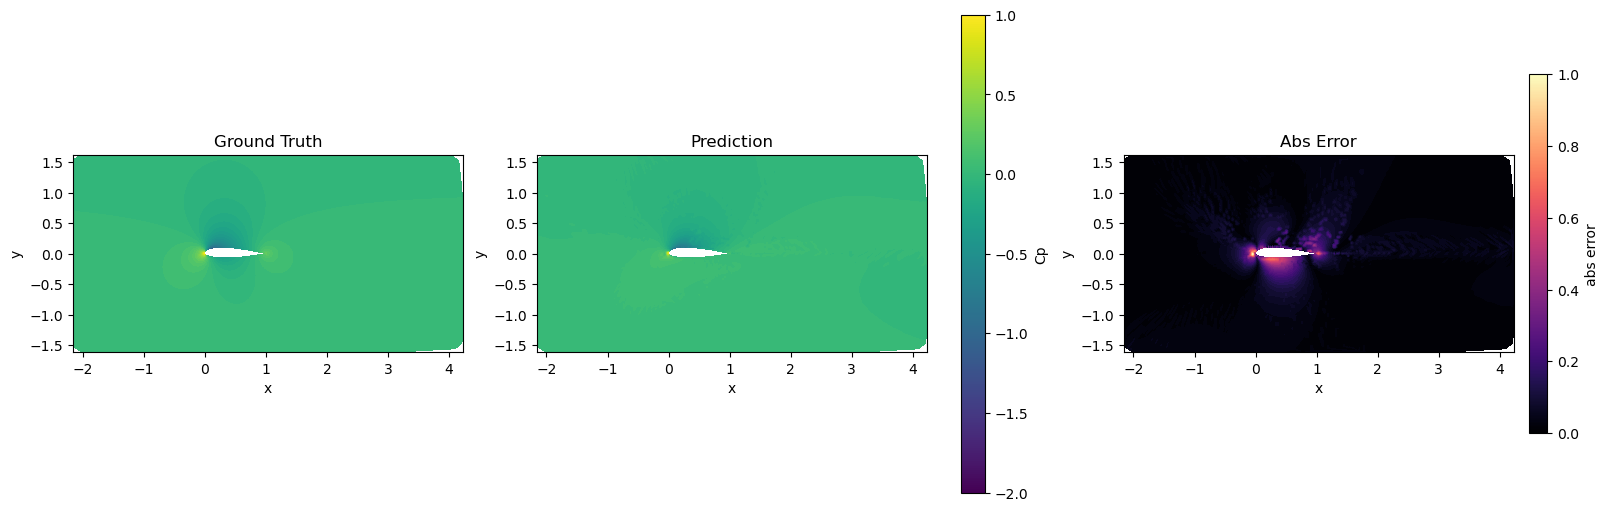

In [21]:
# 15) Visualization: GT vs Prediction (tricontour with optional mask)
from matplotlib.tri import Triangulation

@torch.no_grad()
def _predict_one_for_viz(d: Data):
    # Ensure pos3 + edges, normalize x/y, forward, return normalized dm and y_pred_norm
    dm = Data(**{k: v for k, v in d})
    if dm.x.size(1) == 5 or not getattr(dm, 'pos3_appended', False):
        dm = with_pos3(dm)
    if not hasattr(dm, 'edge_index') or dm.edge_index is None or getattr(dm, 'edge_attr', None) is None:
        dm = build_edges_inline(dm)
    dm_norm = Data(**{k: v for k, v in dm})
    dm_norm.x = x_scaler.transform(dm.x)
    dm_norm.y = y_scaler.transform(dm.y)
    dm_run = dm_norm.to(device)
    with torch.amp.autocast(device_type='cuda', enabled=(scfg.amp and torch.cuda.is_available())) if torch.cuda.is_available() else contextlib.nullcontext():
        y_pred_norm = model(dm_run).detach().cpu()
    return dm_norm, y_pred_norm

@torch.no_grad()
def plot_pred_vs_gt(dm: Data, y_pred: torch.Tensor, channel: int = 2, show_mesh: bool = True, mask_airfoil: bool = True,
                    titles: tuple[str,str,str] = ('Ground Truth','Prediction','Abs Error'), cmap: str = 'viridis',
                    denormalize: bool = True):
    # Optionally denormalize both GT and prediction for visualization
    if denormalize and hasattr(dm, 'y'):
        gt = y_scaler.inverse(dm.y)
        pr = y_scaler.inverse(y_pred)
    else:
        gt = dm.y
        pr = y_pred

    # Prepare coordinates and values
    xy = (dm.pos if hasattr(dm,'pos') and dm.pos is not None else dm.x)[:, :2].detach().cpu().float().numpy()
    tri = Triangulation(xy[:,0], xy[:,1])

    # Denormalize x to compute physical velocity magnitude for q (since dm.x is normalized)
    x_phys = x_scaler.inverse(dm.x)
    vx = float(x_phys[0, 0].cpu())
    vy = float(x_phys[0, 1].cpu())
    v = math.sqrt(vx*vx + vy*vy)
    # For y channel 2 being p_over_rho, Cp uses q = 0.5 * V^2 (rho already divided in target)
    q = 0.5 * v * v

    gt_c = gt[:, channel].detach().cpu().float().numpy() / q
    pr_c = pr[:, channel].detach().cpu().float().numpy() / q
    err = np.abs(pr_c - gt_c)
    vmin = -2.0
    vmax = 1.0

    # Optional mask of airfoil interior
    if mask_airfoil:
        try:
            poly = _poly_from_surface(dm)
            if poly is not None:
                tris = tri.triangles
                centers = np.mean(np.stack([tri.x[tris], tri.y[tris]], axis=-1), axis=1)
                inside = poly.contains_points(centers)
                if inside is not None and inside.any():
                    tri.set_mask(inside)
        except Exception:
            pass

    fig, ax = plt.subplots(1, 3, figsize=(16,5), constrained_layout=True)
    a1,a2,a3 = ax
    c1 = a1.tricontourf(tri, gt_c, levels=50, vmin=vmin, vmax=vmax, cmap=cmap)
    c2 = a2.tricontourf(tri, pr_c, levels=50, vmin=vmin, vmax=vmax, cmap=cmap)
    c3 = a3.tricontourf(tri, err, levels=50, cmap='magma')
    if show_mesh:
        for a in (a1,a2,a3):
            a.triplot(tri, color='k', lw=0.25, alpha=0.35)
    for a, t in zip((a1,a2,a3), titles):
        a.set_aspect('equal','box'); a.set_title(t); a.set_xlabel('x'); a.set_ylabel('y')
    m1 = plt.cm.ScalarMappable(cmap=cmap); m1.set_clim(vmin,vmax)
    fig.colorbar(m1, ax=[a1,a2], fraction=0.046, pad=0.04, label=f'Cp')
    fig.colorbar(plt.cm.ScalarMappable(cmap='magma'), ax=a3, fraction=0.046, pad=0.04, label='abs error')
    plt.show()

# Example: visualize one sample (val if available, else train) — denormalized to capture actual flow physics
if isinstance(val_edges, list) or len(val_edges)==0:
    d_vis = train_edges[0] if len(train_edges)>0 else None
else:
    d_vis = val_edges[0] if len(val_edges)>0 else (train_edges[0] if len(train_edges)>0 else None)

if d_vis is not None:
    dm_vis_n, y_pred_vis_n = _predict_one_for_viz(d_vis)
    # Plot for pressure by default (channel 2). Change channel as needed (0=u, 1=v, 2=p_over_rho, 3=nu_t).
    plot_pred_vs_gt(dm_vis_n, y_pred_vis_n, channel=2, show_mesh=False, denormalize=True)
else:
    print('No sample available for visualization')